In [60]:
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
from pandas import Series
import seaborn as sns
plt.style.use('ggplot')

#def parser(x):
 #   return datetime.strptime('19'+x, '%Y-%m')

app_pr= pd.read_csv('AAPL_data.csv',
                         index_col = ['date'],
                         parse_dates = True,
                        usecols = ['date', 'close'])

app_pr.head(3)


,close
date,
2013-02-08,67.8542
2013-02-11,68.5614
2013-02-12,66.8428


In [61]:
app_pr.tail(3)

,close
date,
2018-02-05,156.49
2018-02-06,163.03
2018-02-07,159.54


### The shape of the Time Series

In [59]:
app_pr.shape

(1259, 5)

In [58]:
type(app_pr)

pandas.core.frame.DataFrame

### Origional and Differencing Series

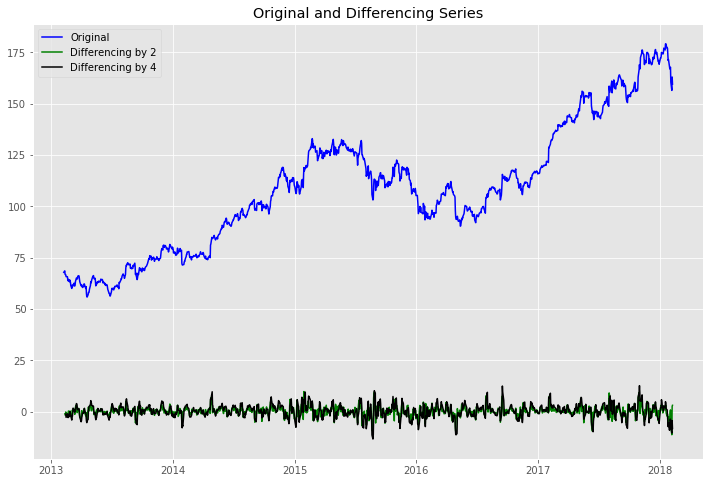

In [62]:

app_diff = app_pr.diff(2)
fig = plt.figure(figsize=(12, 8))
ap = plt.plot(app_pr, color='blue',label='Original')
ap_diff2 = plt.plot(app_pr.diff(2), color='green', label='Differencing by 2')
ap_diff4 = plt.plot(app_pr.diff(4), color='black', label = 'Differencing by 4')
plt.legend(loc='best')
plt.title('Original and Differencing Series')
plt.show()

In [23]:
%pylab inline
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/Users/123/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Decompose the Origonal Series

Dickey-Fuller test: p=0.855586


<Figure size 1080x720 with 0 Axes>

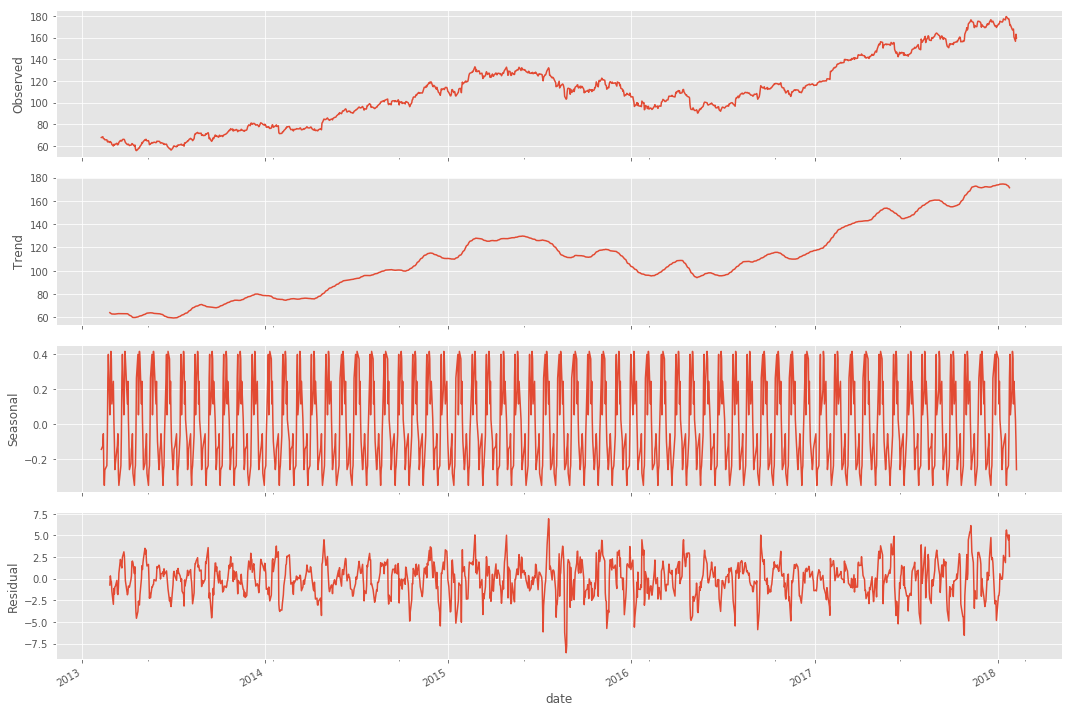

In [24]:
plt.figure(figsize(15,10))
decompfreq = 20
sm.tsa.seasonal_decompose(app_pr,freq=decompfreq).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(app_pr.close)[1])
plt.style.use('ggplot')

In [25]:
app_pr.head(3)

,close
date,
2013-02-08,67.8542
2013-02-11,68.5614
2013-02-12,66.8428


### Dickely Fuller Test

              close
date               
2013-02-08  67.8542
2013-02-11  68.5614
Optimal parameters for box-cox model: 0.408822
Dickely-Fuller test: p=0.814861


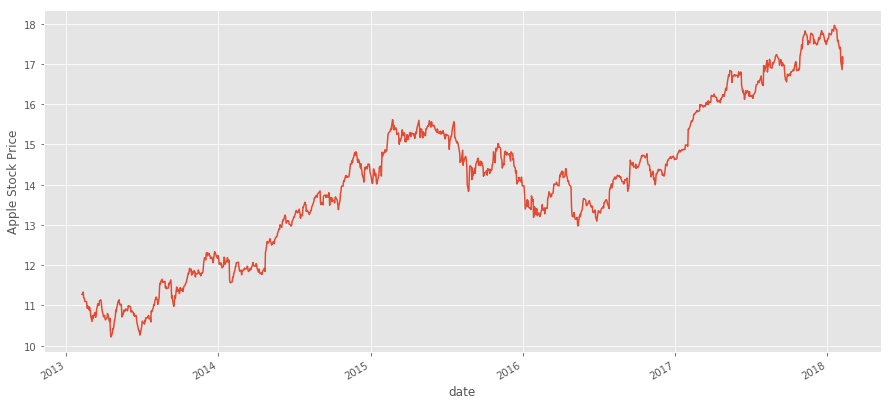

In [26]:
print (app_pr.head(2))
app_pr['elec_box'], lmbda = stats.boxcox(app_pr.close)
plt.figure(figsize(15,7))
app_pr.elec_box.plot()
plt.ylabel(u'Apple Stock Price')
print("Optimal parameters for box-cox model: %f" % lmbda)
print("Dickely-Fuller test: p=%f" % sm.tsa.stattools.adfuller(app_pr.elec_box)[1])

In [27]:
app_pr.head(3)

,close,elec_box
date,,
2013-02-08,67.8542,11.270793
2013-02-11,68.5614,11.329059
2013-02-12,66.8428,11.186835


Dickley-Fuller Test: p=0.000000


<Figure size 1080x720 with 0 Axes>

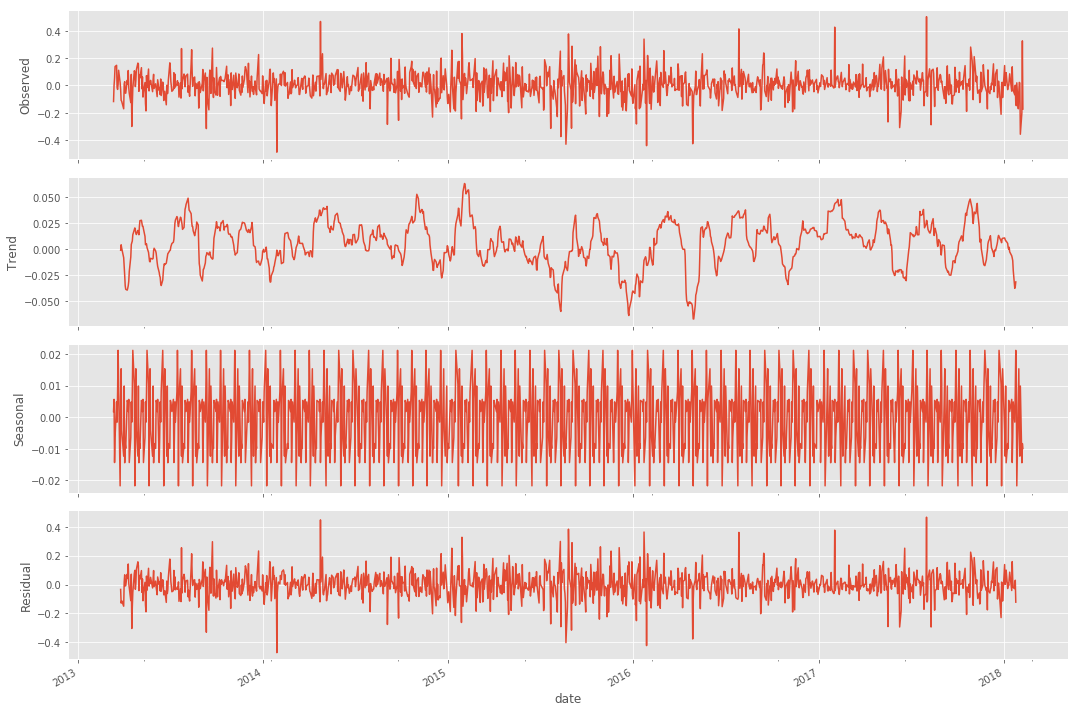

In [28]:
app_pr['elec_box_diff'] = app_pr.elec_box - app_pr.elec_box.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(app_pr.elec_box_diff[21:],freq = decompfreq).plot()
print("Dickley-Fuller Test: p=%f" % sm.tsa.stattools.adfuller(app_pr.elec_box_diff[21:])[1])

In [29]:
app_pr.head(2)

,close,elec_box,elec_box_diff
date,,,
2013-02-08,67.8542,11.270793,NaN
2013-02-11,68.5614,11.329059,0.058267


Dickley-Fuller Test: p=0.000000


<Figure size 1080x720 with 0 Axes>

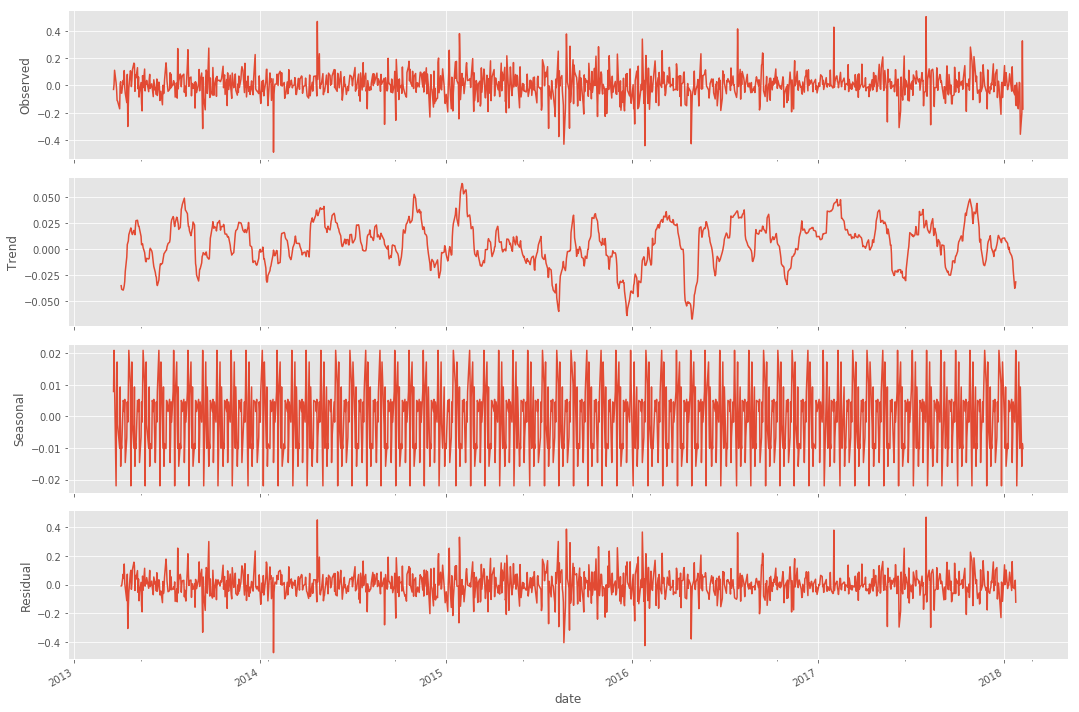

In [30]:
app_pr['elec_box_diff2'] = app_pr.elec_box - app_pr.elec_box.shift(7)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(app_pr.elec_box_diff[27:],freq = decompfreq).plot()
print("Dickley-Fuller Test: p=%f" % sm.tsa.stattools.adfuller(app_pr.elec_box_diff[27:])[1])

### Correlogram 

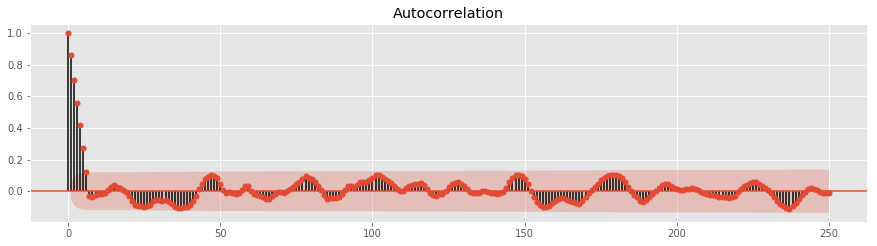

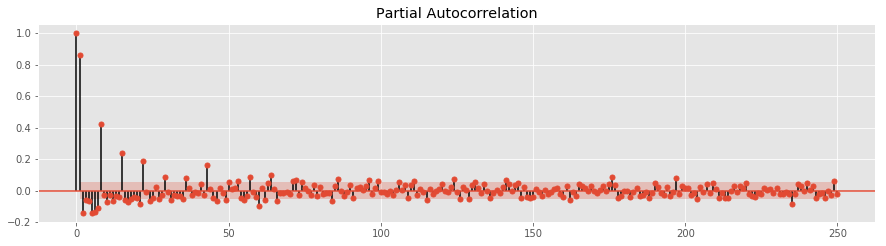

In [31]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(app_pr.elec_box_diff2[21:].values.squeeze(), lags=250, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(app_pr.elec_box_diff2[21:].values.squeeze(), lags=250, ax=ax)
pylab.show()

### ARIMA Model

In [32]:
ps = range(0, 15)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [33]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

180

In [34]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except since for some trys model is not learning
    try:
        model=sm.tsa.statespace.SARIMAX(app_pr.elec_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    # display parameters whre model is bad and mov eto the next one
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #save best model, aic, param
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
CPU times: user 2h 6min 21s, sys: 2min 16s, total: 2h 8min 37s
Wall time: 51min 6s


In [35]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
1   (0, 0, 0, 1) -2208.523297
5   (0, 1, 0, 1) -2207.252353
13  (1, 0, 0, 1) -2207.230666
3   (0, 0, 1, 1) -2207.063285
15  (1, 0, 1, 1) -2205.763477


In [36]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           elec_box   No. Observations:                 1259
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood                1106.262
Date:                            Mon, 26 Nov 2018   AIC                          -2208.523
Time:                                    16:10:08   BIC                          -2198.268
Sample:                                         0   HQIC                         -2204.667
                                           - 1259                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -1.0000     10.709     -0.093      0.926     -21.990      19.990
sigma2         0.0095      0.101   

### Correlogram for ARIMA Model

Student Test: p=0.540393
Dickley-Fuller Test: p=0.000000


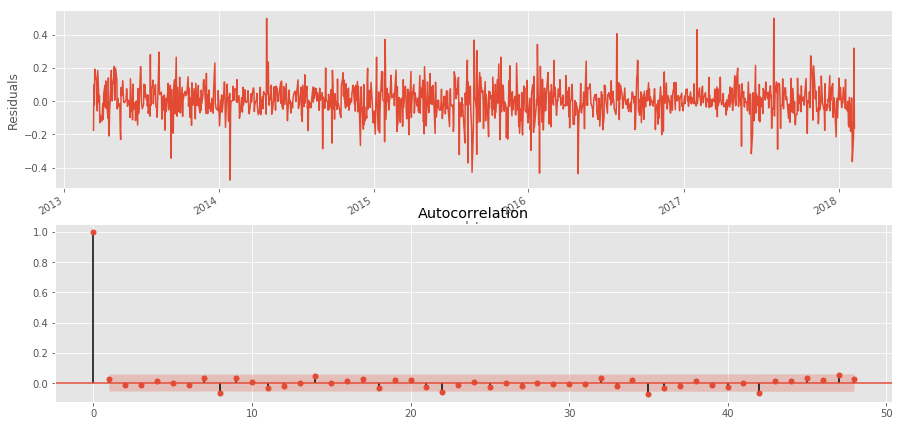

In [37]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[21:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[21:].values.squeeze(), lags=48, ax=ax)

print("Student Test: p=%f" % stats.ttest_1samp(best_model.resid[21:], 0)[1])
print("Dickley-Fuller Test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[21:])[1])

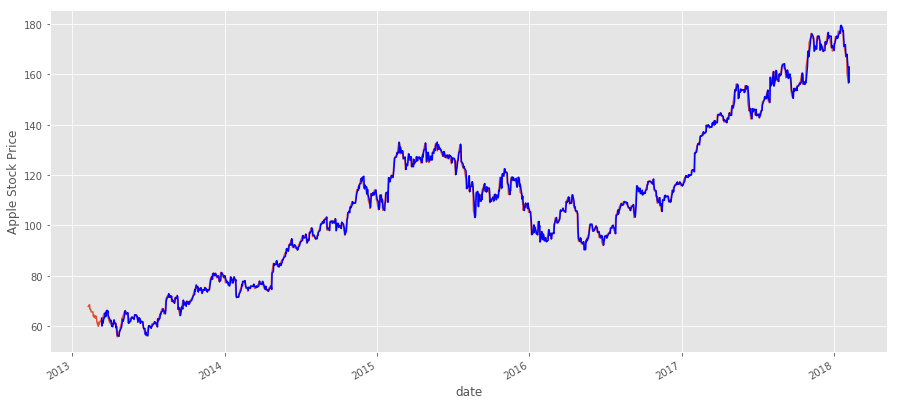

In [38]:
app_pr['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
app_pr.close.plot()
app_pr.model[21:].plot(color='b')
plt.ylabel('Apple Stock Price')
pylab.show()

In [145]:
app_pr.tail(5)

,close,elec_box,elec_box_diff,elec_box_diff2,model
date,,,,,
2018-02-01,167.78,17.414347,0.016948,-0.441014,167.473702
2018-02-02,160.50,17.057421,-0.356926,-0.665110,167.934639
2018-02-05,156.49,16.856718,-0.200703,-0.717841,160.723018
2018-02-06,163.03,17.182527,0.325809,-0.411152,156.645876
2018-02-07,159.54,17.009645,-0.172883,-0.413410,162.839983


### ForeCast

/Users/123/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


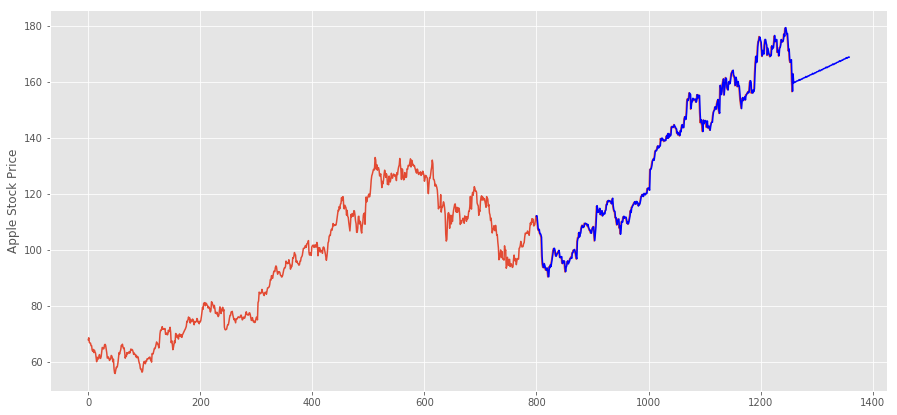

In [51]:
#forecast
app_pr2 = app_pr[['close']]
date_list = [datetime.datetime.strptime("2018-02-08", "%Y-%m-%d") + relativedelta(days=x) for x in range(0,100)]
future = pd.DataFrame(index=date_list, columns= app_pr2.columns)
app_pr2 = pd.concat([app_pr2, future])
predict = invboxcox(best_model.predict(start=800, end=1370), lmbda)
app_pr2= app_pr2.reset_index()
predict=predict.to_frame()
app_pr2['forecast']= predict




plt.figure(figsize(15,7))
app_pr2.close.plot()
app_pr2.forecast.plot(color='b')
plt.ylabel('Apple Stock Price')
pylab.show()

In [40]:
app_pr2

,index,close,forecast
0,2013-02-08,67.8542,NaN
1,2013-02-11,68.5614,NaN
2,2013-02-12,66.8428,NaN
3,2013-02-13,66.7156,NaN
4,2013-02-14,66.6556,NaN
5,2013-02-15,65.7371,NaN
6,2013-02-19,65.7128,NaN
7,2013-02-20,64.1214,NaN
8,2013-02-21,63.7228,NaN
9,2013-02-22,64.4014,NaN


In [171]:
best_model

In [172]:
best_aic

-2208.5232972434305

In [173]:
best_param

(0, 0, 0, 1)

In [187]:
type(app_pr2)

pandas.core.frame.DataFrame